# Modules

In [103]:
# pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 12.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge 
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

#For Warnings
import warnings
warnings.filterwarnings('ignore') 

In [2]:
df_train=pd.read_csv("data/train.csv")
df_test=pd.read_csv("data/test.csv")

In [3]:
df=pd.concat([df_train, df_test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783667 entries, 0 to 783666
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 71.7+ MB


In [4]:
df = df.drop(['User_ID','Product_ID'] , axis = 1)

In [5]:
print(f"Total number of duplicated rows in data are: {df.duplicated().sum()}") 

Total number of duplicated rows in data are: 147232


In [6]:
def cat_cols(df) : 
    o = (df.dtypes == 'object')
    object_cols = o[o].index 
    return object_cols

object_cols = cat_cols(df)
print(f"Categorical Columns are : {object_cols}")

Categorical Columns are : Index(['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years'], dtype='object')


# Features Engineering

## utils 

In [7]:
def missing_vals(df): 
    for i in df :
        if df[i].isnull().sum() > 0 : 
            print(f"{i} : {df[i].isnull().sum()} missing values out of {len(df[i])}")
    else : 
        print("No missing columns.")
        
def splitted_data(features , label) : 
    x_train,x_test,y_train,y_test = train_test_split(features, label , test_size = 0.3)
    
    print(f"Shape of x_train : {x_train.shape}")
    print(f"Shape of y_train : {y_train.shape}")
    print(f"Shape of x_test : {x_test.shape}")
    print(f"Shape of y_test: {y_test.shape}")
    return x_train,x_test,y_train,y_test

In [8]:
age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
df['Age'] = df['Age'].map(age_mapping)


In [9]:
df['Gender'] = df['Gender'].map({'M' : 1 , 'F' : 0})

In [10]:
df['City_Category'] = df['City_Category'].map({'A' : 0 , 'B' : 1, 'C':2})

In [11]:
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].map({ '2' : 2 , '4+' : 4 , '3' : 3, '1' : 1, '0' : 0})


In [12]:
missing_vals(df)

Product_Category_2 : 245982 missing values out of 783667
Product_Category_3 : 545809 missing values out of 783667
Purchase : 233599 missing values out of 783667
No missing columns.


In [13]:
df['Product_Category_2'] = df['Product_Category_2'].fillna(df['Product_Category_2'].mode()[0] )
df['Product_Category_3'] = df['Product_Category_3'].fillna(df['Product_Category_3'].mode()[0] )


In [14]:
df_test = [df['Purchase'].isnull()]
df_train = df[~df['Purchase'].isnull()]

In [15]:
df_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,8.0,16.0,8370.0
1,0,0,10,0,2,0,1,6.0,14.0,15200.0
2,0,0,10,0,2,0,12,8.0,16.0,1422.0
3,0,0,10,0,2,0,12,14.0,16.0,1057.0
4,1,6,16,2,4,0,8,8.0,16.0,7969.0


In [23]:
features = df_train.drop('Purchase' , axis = 1)
label = df_train['Purchase']

In [26]:
x_train,x_test,y_train,y_test = splitted_data(features , label)

Shape of x_train : (385047, 9)
Shape of y_train : (385047,)
Shape of x_test : (165021, 9)
Shape of y_test: (165021,)


# Standard scaler

In [27]:
sc = StandardScaler() 

x_train_columns = x_train.columns
x_test_columns = x_test.columns 

x_train[x_train_columns] = sc.fit_transform(x_train[x_train_columns])
x_test[x_test_columns] = sc.transform(x_test[x_test_columns]) 

In [28]:
x_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
34556,-1.745637,-0.367120,-0.165594,-1.372295,1.660362,-0.832478,1.678119,-0.293344,0.369273
448699,0.572857,-1.105333,-0.625502,-1.372295,-0.666457,1.201232,-1.118493,1.336046,0.369273
243872,0.572857,1.847521,-0.165594,1.259071,-0.666457,1.201232,-0.101543,-0.758884,-2.548806
412965,0.572857,0.371094,1.827342,-1.372295,-1.442063,1.201232,0.661169,1.103276,0.369273
493339,0.572857,0.371094,0.447617,-0.056612,-0.666457,-0.832478,-1.118493,-0.293344,0.369273


In [30]:
y_test

289514    12073.0
169631    19585.0
401967    10047.0
487984    15279.0
224051    12461.0
           ...   
170792    15659.0
121904     9703.0
176939     7001.0
475175     9777.0
49365      1962.0
Name: Purchase, Length: 165021, dtype: float64

# Models

## Linear Regression

In [53]:
pred_dict = {}
lr_model = LinearRegression()
lr_model.fit(x_train , y_train)
lr_y_pred = lr_model.predict(x_test)

pred_dict['Linear_y_pred'] = lr_y_pred 

## Lasso Regression

In [54]:
lasso_model = Lasso()
lasso_model.fit(x_train,y_train)
lasso_y_pred = lasso_model.predict(x_test)
pred_dict['Lasso_y_pred'] = lasso_y_pred

## Ridge Model

In [55]:
ridge_model = Ridge()

ridge_model.fit(x_train,y_train)
ridge_y_pred = ridge_model.predict(x_test)

pred_dict['Ridge_y_pred'] = ridge_y_pred

## Decision Tree Model

In [56]:
tree_model = DecisionTreeRegressor()

tree_model.fit(x_train , y_train)
tree_y_pred = tree_model.predict(x_test)

pred_dict['Tree_y_pred'] = tree_y_pred 

## Random Forest Regression

In [57]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # Usa 100 alberi
rf_regressor.fit(x_train, y_train)

# Predizione sui dati di test
y_pred_rf = rf_regressor.predict(x_test)
pred_dict['RF_y_pred']=y_pred_rf

## Gradient Boosting Machines

In [64]:
gbm_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm_regressor.fit(x_train, y_train)

# Predizione sui dati di test
y_pred_gbm = gbm_regressor.predict(x_test)
pred_dict['GBM_y_pred']=y_pred_gbm

## XGBoost

In [75]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
# Imposto i parametri per XGBoost
params = {
    'max_depth': 3,  # Profondità massima di ciascun albero
    'eta': 0.1,      # Tasso di apprendimento
    'objective': 'reg:squarederror',  # Obiettivo di regressione con errore quadratico
    'eval_metric': 'rmse'  # Metrica di valutazione: Root Mean Squared Error
}
num_round=100
# Addestramento del modello
bst = xgb.train(params, dtrain, num_round)

# Predizione sui dati di test
y_pred_xgb = bst.predict(dtest)
pred_dict['XGB_y_pred']=y_pred_xgb

## Light Gradient Boost

In [97]:
# Creazione del dataset di LightGBM
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# Imposta i parametri per LightGBM
params = {
    'boosting_type': 'gbdt',  # Tipo di algoritmo di boosting (Gradient Boosting Decision Tree)
    'objective': 'regression',  # Obiettivo di regressione
    'metric': {'l2', 'l1'},  # Utilizza MSE (l2) e MAE (l1) come metriche
    'num_leaves': 31,  # Numero di foglie in un albero
    'learning_rate': 0.05,  # Tasso di apprendimento
    'feature_fraction': 0.9,  # Percentuale di feature da considerare ad ogni albero
    'bagging_fraction': 0.8,  # Percentuale di dati da usare per ogni albero
    'bagging_freq': 5,  # Frequenza di bagging
    'verbose': 0  # Meno messaggi di verbose
}

# Numero di round di boosting
num_round = 100
# Addestramento del modello
gbm = lgb.train(params, lgb_train, num_boost_round=num_round, valid_sets=lgb_test)

# Predizione sui dati di test
y_pred_lgbm = gbm.predict(x_test, num_iteration=gbm.best_iteration)
pred_dict['LGB_y_pred']=y_pred_lgbm

## CatBoost

In [112]:
cb_regressor = CatBoostRegressor(
    iterations=100,
    learning_rate=0.01,
    depth=3,
    loss_function='RMSE',
    verbose=10,  # Stampa l'output ogni 10 iterazioni
    random_seed=42
)
# Addestramento del modello
cb_regressor.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True)

# Predizione sui dati di test
y_pred_cb = cb_regressor.predict(x_test)
pred_dict['CB_y_pred']=y_pred_cb

0:	learn: 4998.9103391	test: 5009.6229234	best: 5009.6229234 (0)	total: 29.3ms	remaining: 2.9s
10:	learn: 4809.7033434	test: 4820.9134925	best: 4820.9134925 (10)	total: 272ms	remaining: 2.2s
20:	learn: 4646.5190282	test: 4658.1005149	best: 4658.1005149 (20)	total: 491ms	remaining: 1.85s
30:	learn: 4506.5774290	test: 4518.4438817	best: 4518.4438817 (30)	total: 717ms	remaining: 1.59s
40:	learn: 4385.3134462	test: 4397.2992221	best: 4397.2992221 (40)	total: 933ms	remaining: 1.34s
50:	learn: 4276.7686074	test: 4288.8750536	best: 4288.8750536 (50)	total: 1.15s	remaining: 1.11s
60:	learn: 4182.1571256	test: 4194.4036940	best: 4194.4036940 (60)	total: 1.37s	remaining: 878ms
70:	learn: 4103.4726825	test: 4115.8299160	best: 4115.8299160 (70)	total: 1.59s	remaining: 652ms
80:	learn: 4036.2166710	test: 4048.6676156	best: 4048.6676156 (80)	total: 1.82s	remaining: 427ms
90:	learn: 3974.5684416	test: 3986.9831244	best: 3986.9831244 (90)	total: 2.04s	remaining: 201ms
99:	learn: 3924.4131355	test: 393

In [113]:
del pred_dict['Original_y_test']

In [114]:
del res_df

In [115]:
pred_dict['Original_y_test'] = y_test 

In [116]:
res_df = pd.DataFrame(pred_dict)

res_df.head()

,Linear_y_pred,Lasso_y_pred,Ridge_y_pred,Tree_y_pred,RF_y_pred,GBM_y_pred,XGB_y_pred,LGB_y_pred,CB_y_pred,Original_y_test
289514,12570.513749,12569.372176,12570.510162,15070.428571,15441.868329,13395.225432,13404.094727,13516.914786,11840.185798,12073.0
169631,10917.673015,10917.637472,10917.666584,14481.857143,14812.887551,13136.063932,13126.774414,13099.556975,11840.185798,19585.0
401967,8554.483453,8552.538738,8554.483280,9793.000000,8649.687885,7789.989294,7886.058594,8038.430365,8161.565730,10047.0
487984,10432.041721,10431.863793,10432.037195,15827.000000,15422.878286,13116.150887,13142.212891,13161.014982,11840.185798,15279.0
224051,9269.292523,9268.057303,9269.292841,16386.666667,16605.236405,15517.710633,15495.346680,15881.764436,11609.596173,12461.0


In [1]:
res_df.to_csv('data/res/Model_predictions.csv' , index = False)

NameError: name 'res_df' is not defined

# Model Comparison

## Regression metrics

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def regression_metrics(y_test, y_pred, model_name='Model'):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)*100
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 (%)': r2
    }
    
    print(f"Metrics for {model_name}:")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}%")
    
    return metrics

# Esempio di utilizzo
# Assumendo che y_test sia definito e pred_dict contenga le predizioni per vari modelli
metrics_linear = regression_metrics(y_test, pred_dict['Linear_y_pred'], 'Linear Regression')
metrics_lasso = regression_metrics(y_test, pred_dict['Lasso_y_pred'], 'Lasso Regression')
metrics_ridge = regression_metrics(y_test, pred_dict['Ridge_y_pred'], 'Ridge Regression')
metrics_tree = regression_metrics(y_test, pred_dict['Tree_y_pred'], 'Decision Tree Regression')
metrics_rf = regression_metrics(y_test, pred_dict['RF_y_pred'], 'Random Forest Regression')
metrics_gbm = regression_metrics(y_test, pred_dict['GBM_y_pred'], 'Gradient Boosting Regression')
metrics_xgb = regression_metrics(y_test, pred_dict['XGB_y_pred'], 'XG Boosting Regression')
metrics_lgb = regression_metrics(y_test, pred_dict['LGB_y_pred'], 'Light Gradient Boosting Regression')
metrics_cb = regression_metrics(y_test, pred_dict['CB_y_pred'], 'CatBoosting Regression')


Metrics for Linear Regression:
  MSE: 22025697.84
  RMSE: 4693.15
  MAE: 3588.87
  R²: 0.130
Metrics for Lasso Regression:
  MSE: 22025601.63
  RMSE: 4693.14
  MAE: 3588.96
  R²: 0.130
Metrics for Ridge Regression:
  MSE: 22025697.77
  RMSE: 4693.15
  MAE: 3588.87
  R²: 0.130
Metrics for Decision Tree Regression:
  MSE: 10997810.54
  RMSE: 3316.29
  MAE: 2354.04
  R²: 0.565
Metrics for Random Forest Regression:
  MSE: 9280139.74
  RMSE: 3046.33
  MAE: 2222.35
  R²: 0.633
Metrics for Gradient Boosting Regression:
  MSE: 8920188.12
  RMSE: 2986.67
  MAE: 2266.76
  R²: 0.648
Metrics for XG Boosting Regression:
  MSE: 8916563.20
  RMSE: 2986.06
  MAE: 2266.41
  R²: 0.648
Metrics for Light Gradient Boosting Regression:
  MSE: 8673220.87
  RMSE: 2945.03
  MAE: 2223.28
  R²: 0.657
Metrics for CatBoosting Regression:
  MSE: 15498775.61
  RMSE: 3936.85
  MAE: 2970.23
  R²: 0.388


The output  shows very similar results in terms of **MSE** (Mean Squared Error), **RMSE** (Root Mean Squared Error), **MAE** (Mean Absolute Error), and **R²** (coefficient of determination).

The regularisation introduced by **Lasso** and **Ridge** does not lead to significant improvements over standard linear regression. The relatively low R² (0.13) for these models indicates that only a small part of the variance is explained by the models.

**Decision Tree Regression** performs significantly better than the linear models, with lower MSE and RMSE values and a better MAE. More importantly, the value of R² is much higher (0.56), indicating that this model is able to explain a larger portion of the variance in the test data. This could suggest that the dataset has a non-linear structure or relationships that the decision tree model is able to capture better than linear models.

**Random Forest Regressor** outperformed all other models tested. This is consistent with expectations, as decision tree-based models and, in particular, ensembles such as Random Forest tend to be more flexible and powerful, capturing complexities and non-linear relationships in the data better than linear models.

From the results obtained for the **Gradient Boosting Regression**, we can see that this model outperformed the Random Forest and all other previously tested models in terms of all key metrics. With an R² value of 0.65, this model shows a superior ability to explain variance in the test data compared to the other models, indicating a good fit and prediction of performance on the data.

The results obtained for the **XGBoost Regression** show very similar performance to the Gradient Boosting Regression. This indicates that XGBoost, like Gradient Boosting, is very effective in capturing complex relationships and non-linear dynamics in the data, offering accurate predictions and a high degree of variance explanation in the test data.

The results for **Light Gradient Boosting Regression** show a further improvement over the other models tested previously. LightGBM proved to be particularly effective in handling large datasets while maintaining a high training speed without compromising model quality. This is due to its gradient-based tree construction strategy and its efficient handling of categorical features.

**CatBoost** has a significantly higher MSE and RMSE than the Gradient Boosting, XGBoost and LightGBM models, but better than the linear models (Linear, Lasso, Ridge Regression). This indicates that although CatBoost has not reached the peak performance of some tree-based models, it still outperforms the linear models in terms of mean square error.

In [4]:
res_df=pd.read_csv('data/res/Model_predictions.csv')

In [5]:
res_df.head()

,Linear_y_pred,Lasso_y_pred,Ridge_y_pred,Tree_y_pred,RF_y_pred,GBM_y_pred,XGB_y_pred,LGB_y_pred,CB_y_pred,Original_y_test
0,12570.513749,12569.372176,12570.510162,15070.428571,15441.868329,13395.225432,13404.0950,13516.914786,11840.185798,12073.0
1,10917.673015,10917.637472,10917.666584,14481.857143,14812.887551,13136.063932,13126.7740,13099.556975,11840.185798,19585.0
2,8554.483453,8552.538738,8554.483280,9793.000000,8649.687885,7789.989294,7886.0586,8038.430365,8161.565730,10047.0
3,10432.041721,10431.863793,10432.037195,15827.000000,15422.878286,13116.150887,13142.2130,13161.014982,11840.185798,15279.0
4,9269.292523,9268.057303,9269.292841,16386.666667,16605.236405,15517.710633,15495.3470,15881.764436,11609.596173,12461.0


### MSE comparison

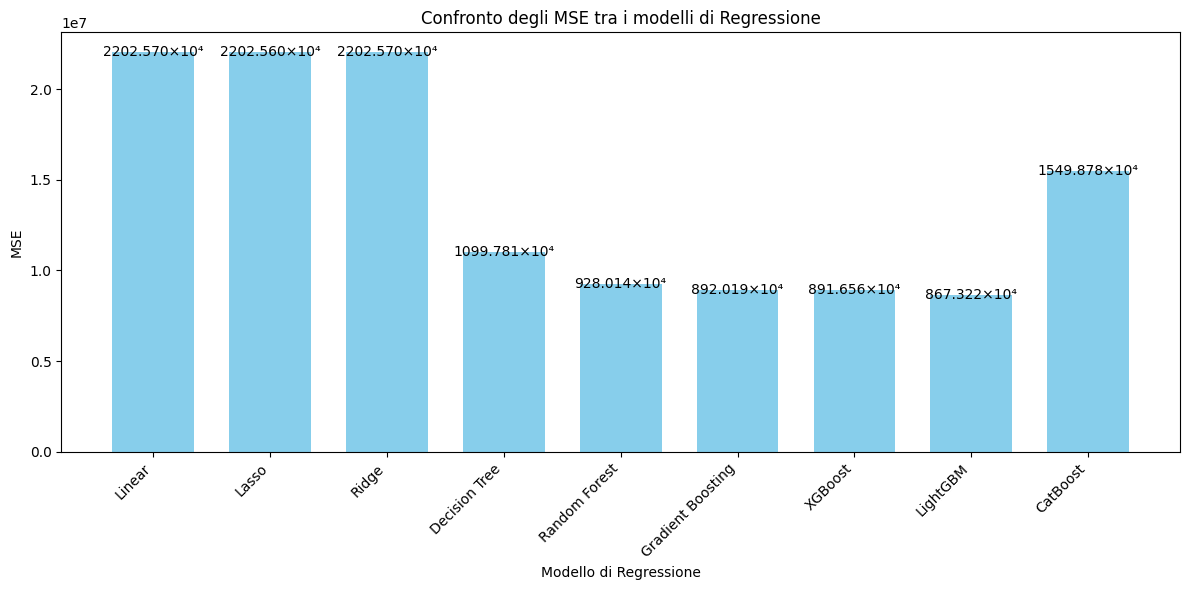

In [27]:
mse_values = [22025697.84, 22025601.63, 22025697.77, 10997810.54, 9280139.74, 8920188.12, 8916563.20, 8673220.87, 15498775.61]
mse_values_sci = [f"{x / 1e4:.3f}×10⁴" for x in mse_values]

# Creazione del grafico a barre
plt.figure(figsize=(12, 6))
bars = plt.bar(models, mse_values, color='skyblue', width=0.7)

# Aggiunta del valore esatto su ogni barra
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1000, mse_values_sci[i], va='center', ha='center') 

plt.xlabel('Modello di Regressione')
plt.ylabel('MSE')
plt.title('Confronto degli MSE tra i modelli di Regressione')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Salvataggio del grafico in un file png
plt.savefig('res/models plots/MSE_comparison.png')

# Mostrare il grafico
plt.show()


### RMSE comparison

<Figure size 1000x600 with 0 Axes>

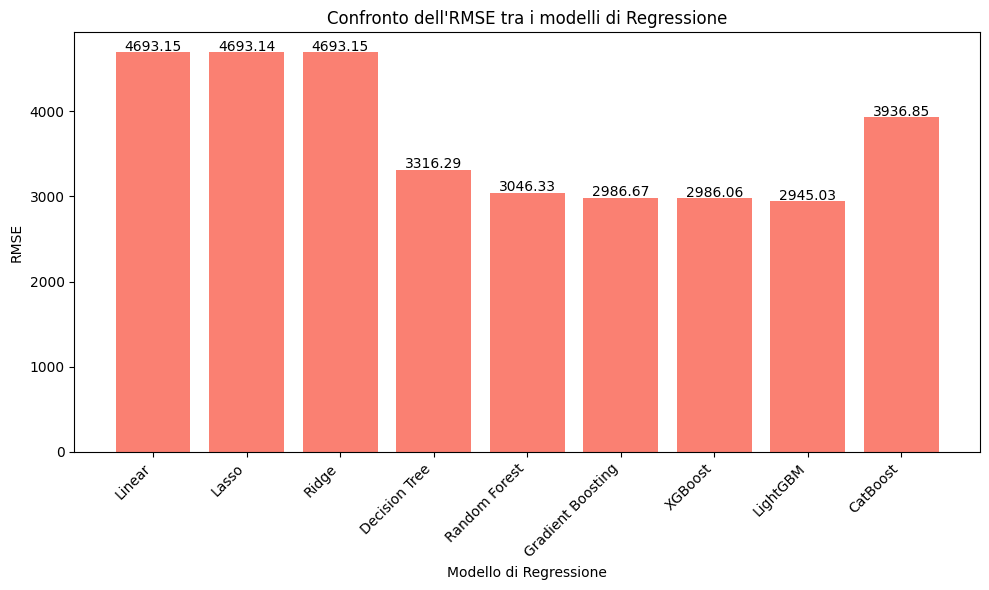

In [16]:
import matplotlib.pyplot as plt

# Nomi dei modelli
models = ['Linear', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']

# RMSE per ogni modello
rmse_values = [4693.15, 4693.14, 4693.15, 3316.29, 3046.33, 2986.67, 2986.06, 2945.03, 3936.85]

# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
bars = plt.bar(models, rmse_values, color='salmon')

# Aggiunta del valore esatto su ogni barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval+60, round(yval, 2), va='center', ha='center') # arrotondato a 2 cifre decimali

plt.xlabel('Modello di Regressione')
plt.ylabel('RMSE')
plt.title('Confronto dell\'RMSE tra i modelli di Regressione')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Mostrare il grafico
plt.savefig('res/models plots/RSME_comparison.png')
plt.show()


### MAE comparison

<Figure size 1000x600 with 0 Axes>

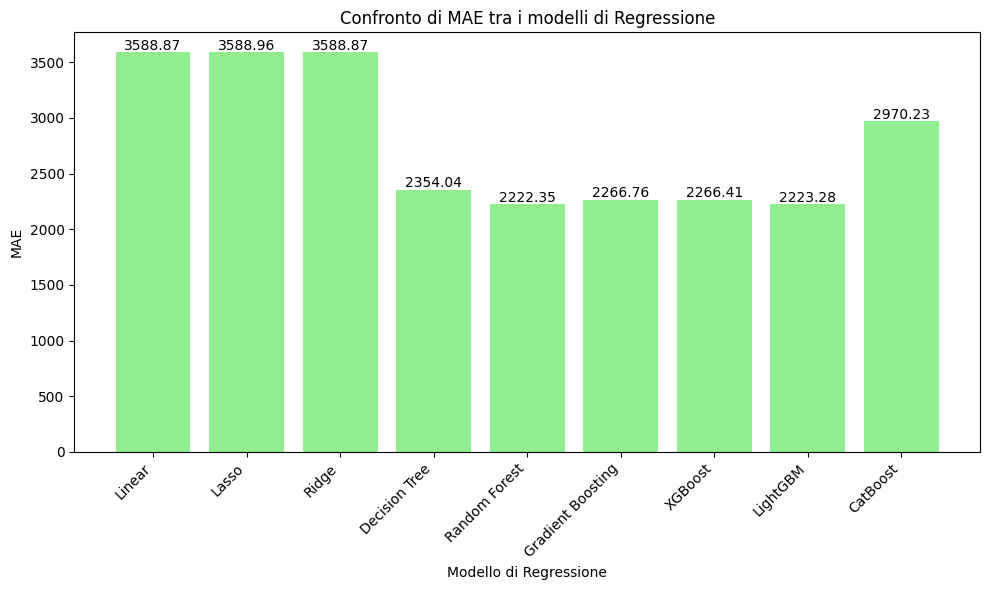

In [31]:
mae_values = [3588.87, 3588.96, 3588.87, 2354.04, 2222.35, 2266.76, 2266.41, 2223.28, 2970.23]
# Creazione del grafico a barre
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color='lightgreen')

# Aggiunta del valore esatto su ogni barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval+60,yval, va='center', ha='center') # arrotondato a 2 cifre decimali

plt.xlabel('Modello di Regressione')
plt.ylabel('MAE')
plt.title('Confronto di MAE tra i modelli di Regressione')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Mostrare il grafico
plt.savefig('res/models plots/MAE_comparison.png')
plt.show()

### R2

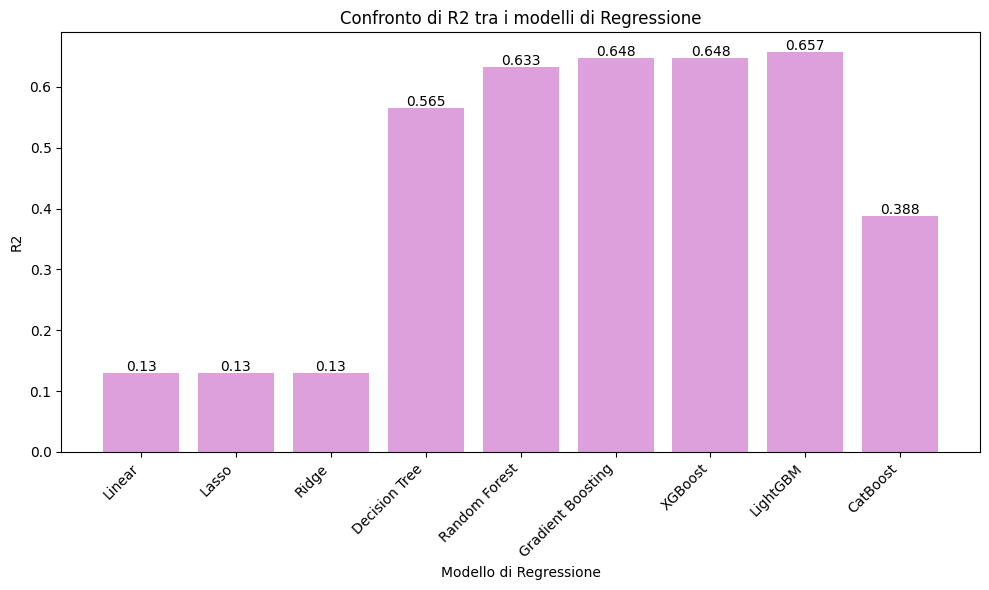

In [44]:
r2_values = [0.130, 0.130, 0.130, 0.565, 0.633, 0.648, 0.648, 0.657, 0.388]# Creazione del grafico a barre
plt.figure(figsize=(10, 6))

bars = plt.bar(models, r2_values, color='plum')

# Aggiunta del valore esatto su ogni barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval+0.01,yval, va='center', ha='center') # arrotondato a 2 cifre decimali

plt.xlabel('Modello di Regressione')
plt.ylabel('R2')
plt.title('Confronto di R2 tra i modelli di Regressione')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Mostrare il grafico
plt.savefig('res/models plots/R2_comparison.png')
plt.show()